# Импорты

In [7]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import classification_report, roc_curve, r2_score, mean_squared_error

from decision_tree import *
from gradient_boosting import *
from random_forest import *

# Функции для отрисовки

In [12]:
def show_histplot(data: pd.DataFrame, feature_name: str):
    sns.histplot(data, kde=True, binwidth=0.1)
    plt.xlabel(f'Значения {feature_name}')
    plt.ylabel('Частота')
    plt.title(f'Распределение {feature_name}')
    plt.show()


def get_boxplot(df_column, column_name):
    pd.DataFrame(df_column).boxplot(sym='o', whis=1.0, showmeans=True)
    plt.show()

def get_heatmap(df: pd.DataFrame):
    sns.heatmap(df)

def get_3d(param1: list[int], param2: list[int], result: list[int], name_param1: str, name_param2: str):
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    ax.plot3D(param1, param2, result, 'green')
    ax.set_title(f'Зависимость метрики R² от {name_param1} и {name_param2}')
    plt.show()

def get_2d(param1: list[int], result: list[int], name_param1: str):
    plt.title(f'Зависимость метрики R² от {name_param1}')
    plt.plot(param1, result)


def output_roc_auc(y_test: pd.Series, preds: pd.Series):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(y_test, preds, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

def plot_variance(pca, width=8, dpi=100):
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    fig.set(figwidth=8, dpi=100)
    return axs

def get_bias_variance(model_param, bias_model, var_model,
                      avg_model, name_param, name_model):
    plt.figure(figsize=(10,5))
    plt.xlabel(f'Different Values of {name_param}')
    plt.ylabel(f'Tradeoff bias-variance {name_model}')
    plt.plot(model_param, bias_model, color = 'r', label = "avg_bias")
    plt.plot(model_param, var_model, color = 'b', label = 'avg_var')
    plt.plot(model_param, avg_model, color = 'g', label = 'avg_tree')
    plt.legend(bbox_to_anchor=(1, 1),bbox_transform=plt.gcf().transFigure)
    plt.show()

# Всякие полезные функции

In [44]:
# Evaluation function
def evaluation(model_name, y_test, y_pred_test, output=False):
    r2_test = r2_score(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    if output:
        print(f'\n{model_name} Evaluation:')
        print(f'Test R²: {r2_test:.7f}')
        print(f'Test RMSE: {rmse_test:.5f}')
    return r2_test

def output_metrics_classification(y_test: pd.Series, preds: pd.Series):
    report = classification_report(y_test, preds, output_dict=True)
    return report

def show_dependencies(num_layers, train_results, test_results):
    plt.figure(figsize=(10, 6))
    plt.plot(num_layers, test_results, marker='o', label='Test Results', color='b')
    plt.plot(num_layers, train_results, marker='o', label='Train Results', color='g')
    plt.title('Зависимость тестовых и тренировочных результатов от количества слоев')
    plt.xlabel('Количество estimators')
    plt.ylabel('Результаты')
    plt.xticks(num_layers)
    plt.grid(True)
    plt.legend()

# Импорт датасета

Пол/Возраст/Рост/Вес - это физические характеристики

family_history_with_overweight -  семейная история с избыточным весом

FAVC - Частое употребление высококалорийной пищи

FCVC - Частота употребления овощей

NCP - Количество основных приемов пищи

CAEC - Количество приемов пищи между приемами пищи

SMOKE - употребление табака

CH20 - Ежедневное потребление воды

SCC - Контроль потребления калорий

FAF - Частота физической активности

ВТ - Время, в течение которого вы пользуетесь техническими устройствами

CALC - Потребление алкоголя

MTRANS - Использованный транспорт

In [18]:
df = pd.read_csv('data/train_fat.csv')
df = df.sample(n=2000, random_state=42)
df = df.drop('id', axis=1)
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
10317,Female,26.000000,1.649178,111.933010,yes,yes,3.000000,3.0,Sometimes,no,1.292479,no,0.065264,0.711331,Sometimes,Public_Transportation,Obesity_Type_III
4074,Male,18.000000,1.750000,80.000000,no,yes,2.000000,3.0,Sometimes,no,2.000000,no,1.000000,1.000000,Sometimes,Public_Transportation,Overweight_Level_I
9060,Female,23.360307,1.713380,84.722222,yes,yes,2.880161,3.0,Sometimes,no,2.847264,no,2.000000,0.002600,no,Public_Transportation,Obesity_Type_I
11286,Male,30.002029,1.670667,112.000381,yes,yes,1.572036,3.0,Sometimes,no,2.003563,no,0.000000,0.114457,Sometimes,Public_Transportation,Obesity_Type_II
8254,Male,17.000000,1.610000,50.000000,no,yes,2.000000,3.0,Sometimes,no,2.000000,no,0.000000,2.000000,no,Public_Transportation,Insufficient_Weight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10663,Male,17.000000,1.650000,85.000000,yes,no,2.000000,3.0,Sometimes,no,3.000000,no,1.000000,1.000000,no,Public_Transportation,Obesity_Type_I
15917,Male,24.000000,1.700000,85.000000,yes,yes,2.000000,3.0,Sometimes,no,2.000000,no,1.000000,2.000000,Sometimes,Public_Transportation,Overweight_Level_II
12904,Male,55.022494,1.650000,80.000000,yes,yes,2.000000,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Automobile,Overweight_Level_II
13355,Female,26.000000,1.580000,78.000000,no,no,2.000000,1.0,no,no,3.000000,no,1.000000,2.000000,Frequently,Public_Transportation,Overweight_Level_I


# Label Encoding

In [19]:
categorical_features = df.columns[df.dtypes=="object"].tolist()
numeric_features = df.columns[df.dtypes!="object"].tolist()

label_encoder = LabelEncoder()
for feature in categorical_features:
    df[feature] = label_encoder.fit_transform((df.loc[:, feature]))

categorical_features = df.columns[df.dtypes=="bool"].tolist()
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
10317,0,26.000000,1.649178,111.933010,1,1,3.000000,3.0,2,0,1.292479,0,0.065264,0.711331,1,3,4
4074,1,18.000000,1.750000,80.000000,0,1,2.000000,3.0,2,0,2.000000,0,1.000000,1.000000,1,3,5
9060,0,23.360307,1.713380,84.722222,1,1,2.880161,3.0,2,0,2.847264,0,2.000000,0.002600,2,3,2
11286,1,30.002029,1.670667,112.000381,1,1,1.572036,3.0,2,0,2.003563,0,0.000000,0.114457,1,3,3
8254,1,17.000000,1.610000,50.000000,0,1,2.000000,3.0,2,0,2.000000,0,0.000000,2.000000,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10663,1,17.000000,1.650000,85.000000,1,0,2.000000,3.0,2,0,3.000000,0,1.000000,1.000000,2,3,2
15917,1,24.000000,1.700000,85.000000,1,1,2.000000,3.0,2,0,2.000000,0,1.000000,2.000000,1,3,6
12904,1,55.022494,1.650000,80.000000,1,1,2.000000,3.0,2,0,2.000000,0,0.000000,1.000000,2,0,6
13355,0,26.000000,1.580000,78.000000,0,0,2.000000,1.0,3,0,3.000000,0,1.000000,2.000000,0,3,5


# EDA: Obesity Risk

## Чекаем дупликаты и Nan

In [20]:
print(f"Number of missing value:{df.isna().sum().sum()}")
print(f"Number of duplicated value:{df.duplicated().sum()}")

Number of missing value:0
Number of duplicated value:0


In [21]:
df = df.dropna(axis=0)

## Распределение признаков

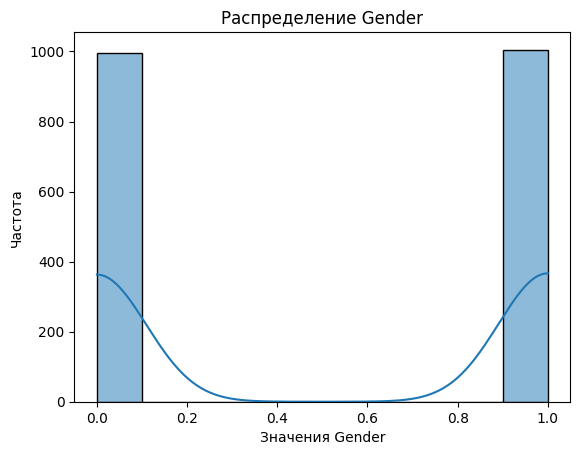

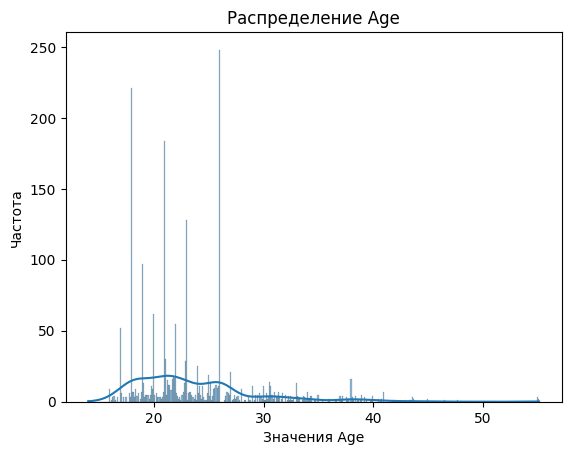

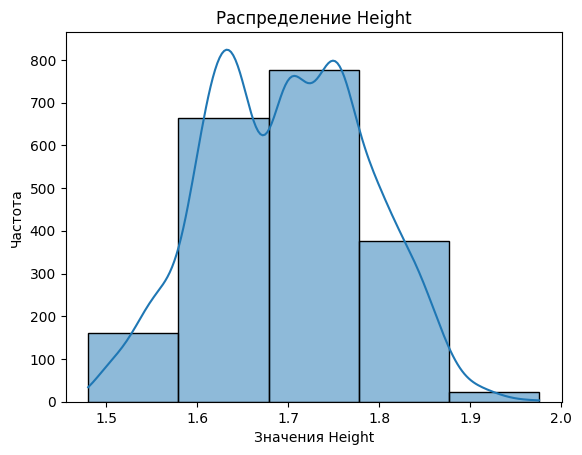

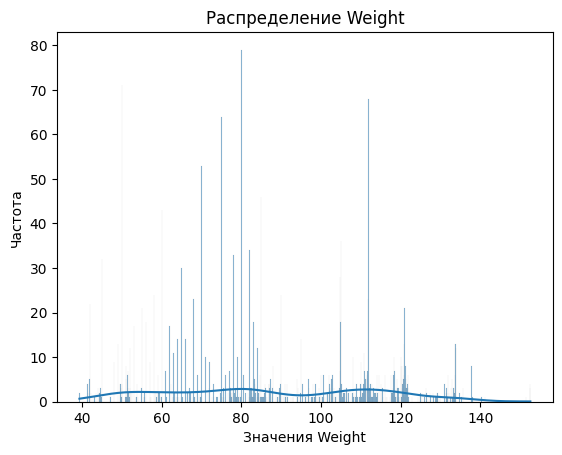

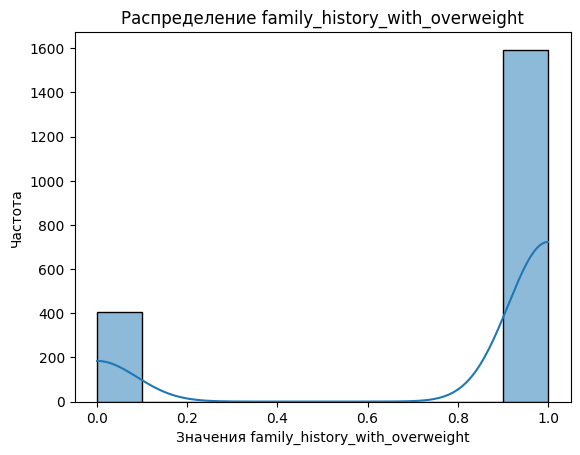

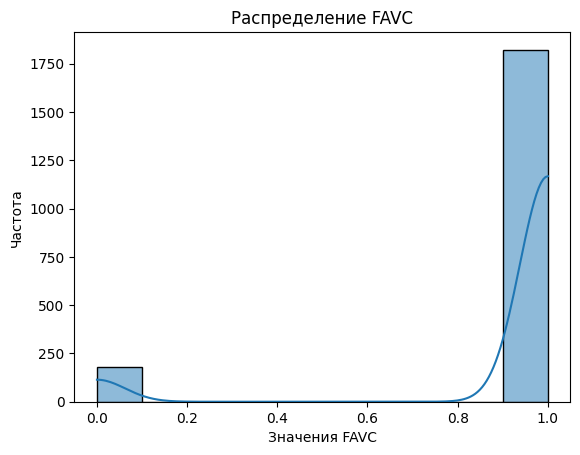

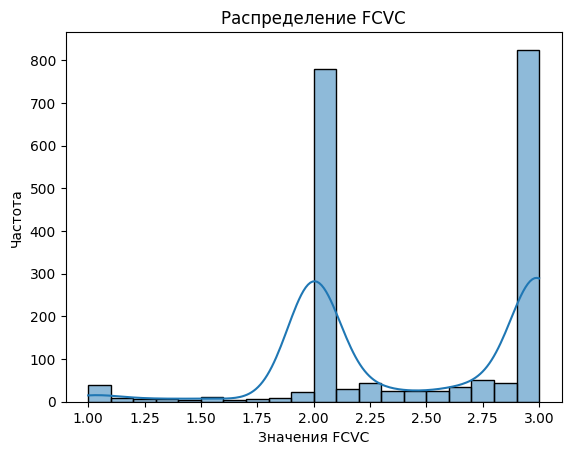

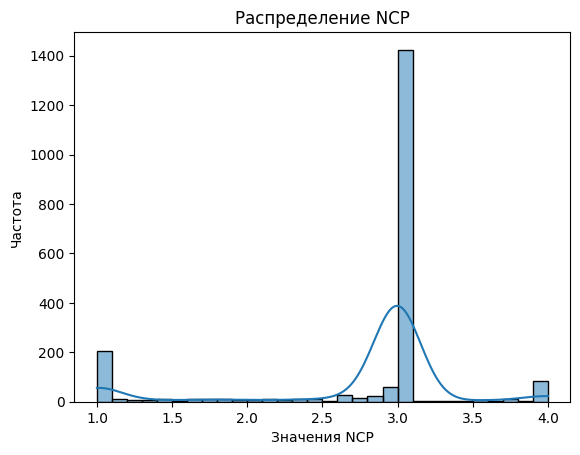

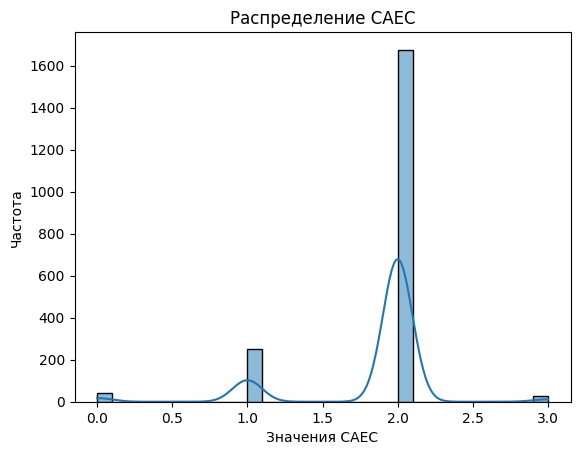

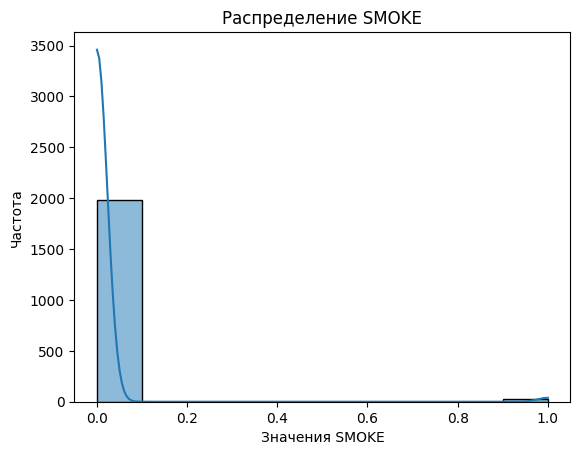

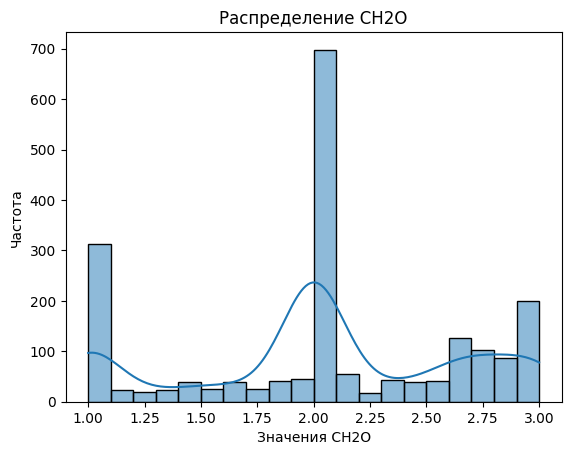

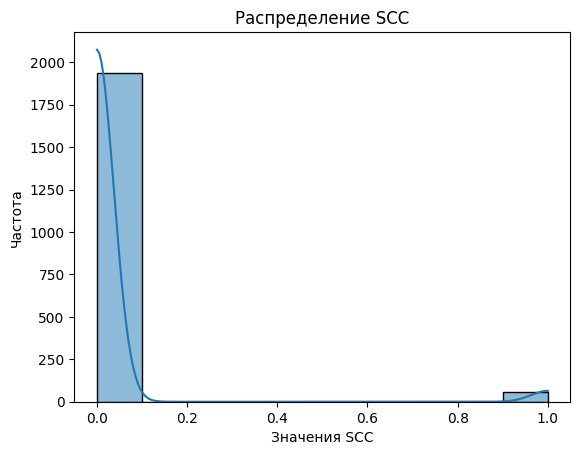

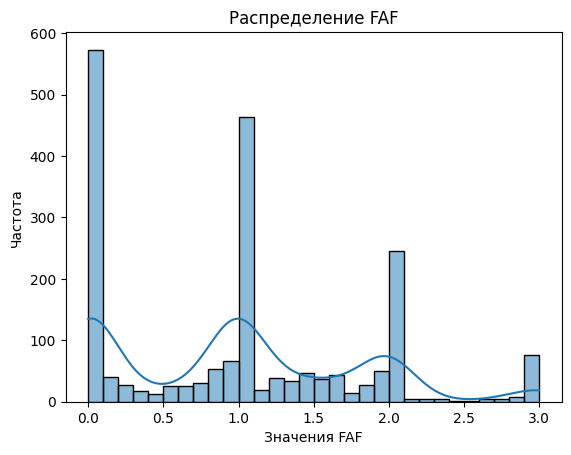

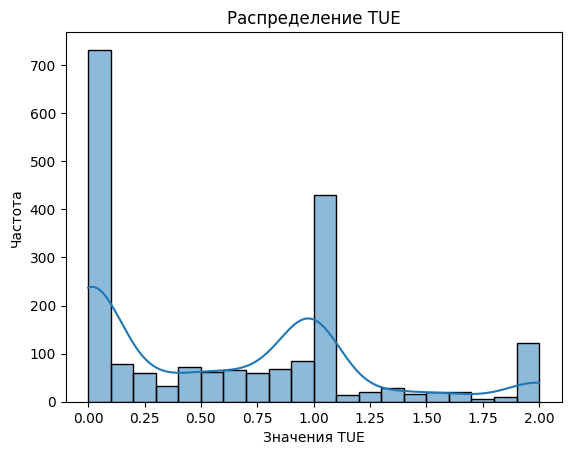

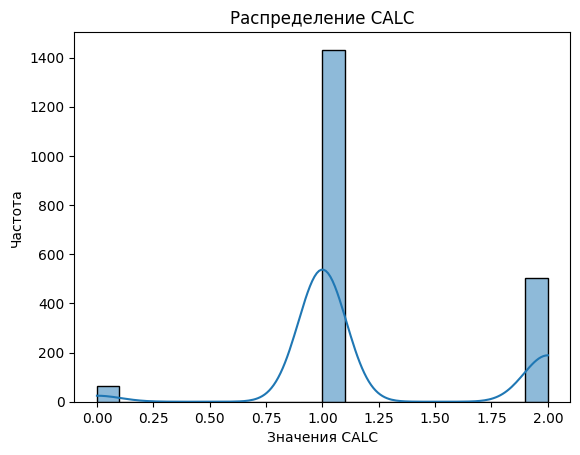

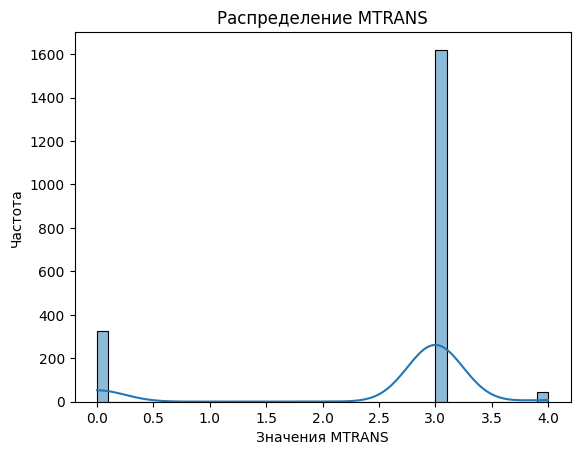

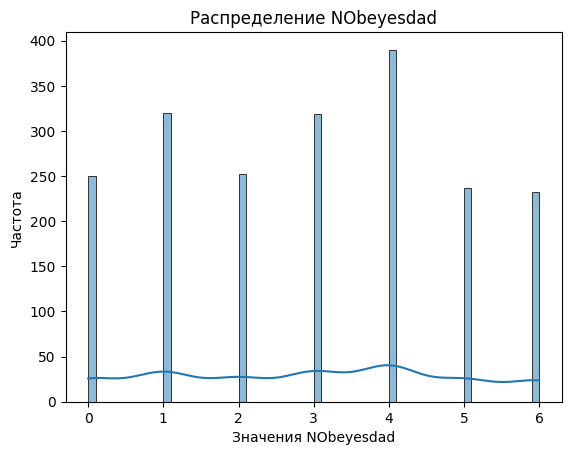

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [22]:
[show_histplot(df[column], column) for column in df.columns]

**Итог**

Таргет имеет гипергеометрическое распределение, то есть модели будет относительно сложно его повторить. Спасибо, что не рандомное.

## Выбросы

### Ящики с усами

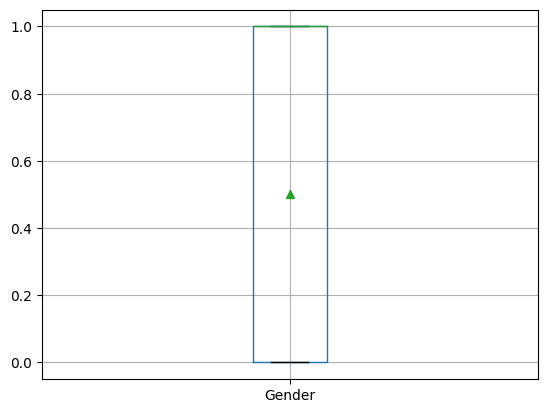

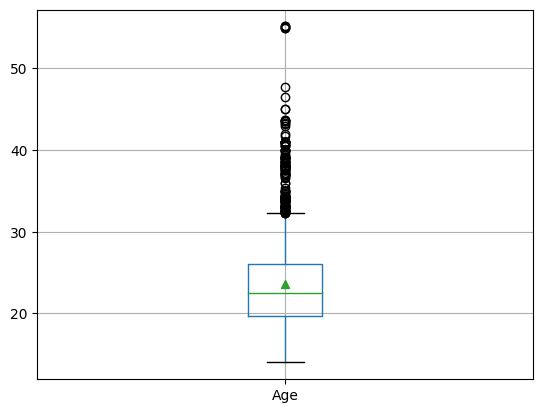

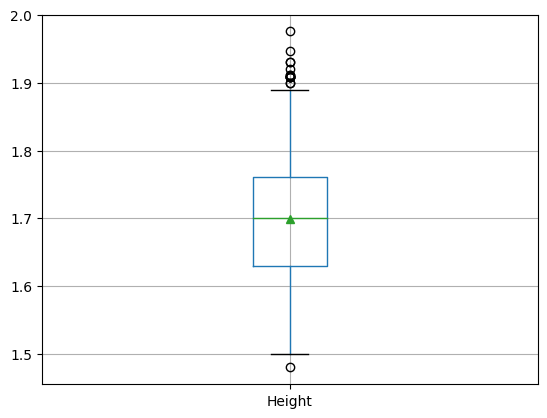

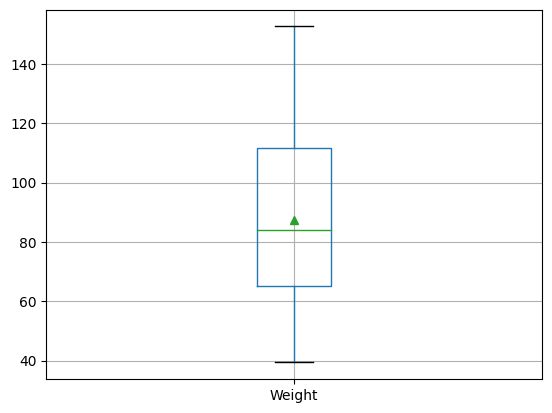

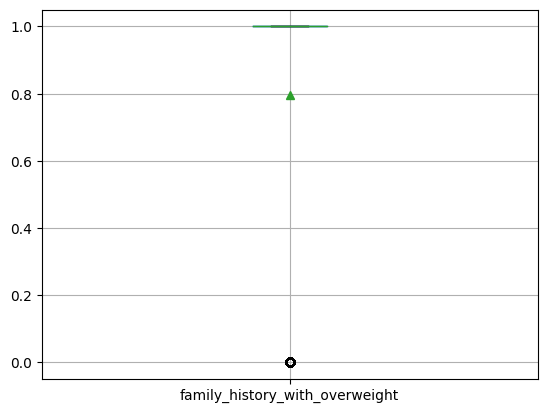

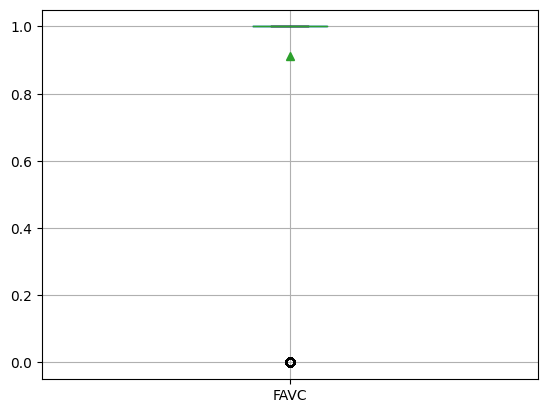

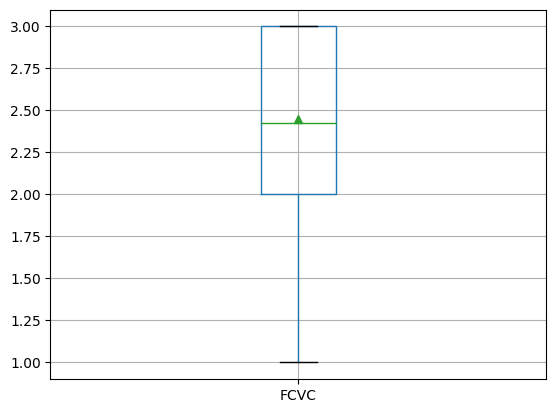

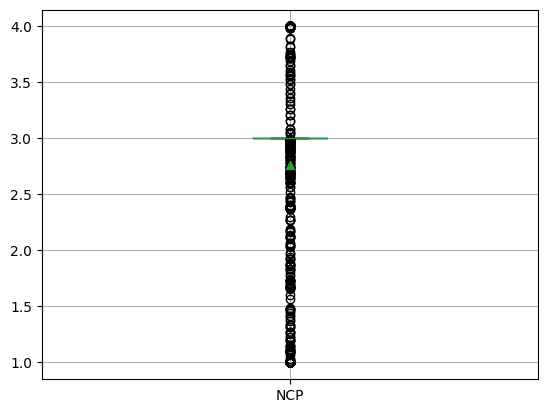

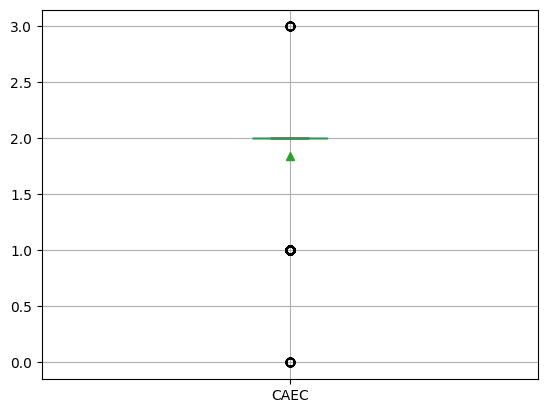

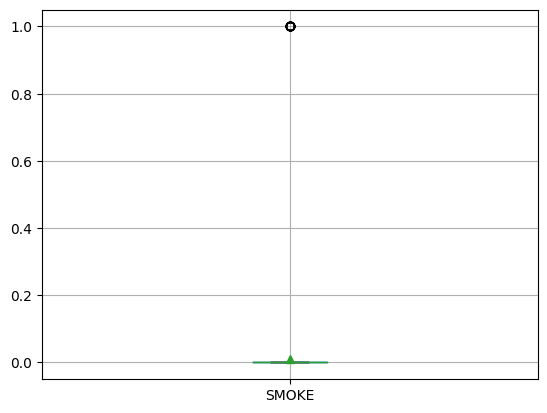

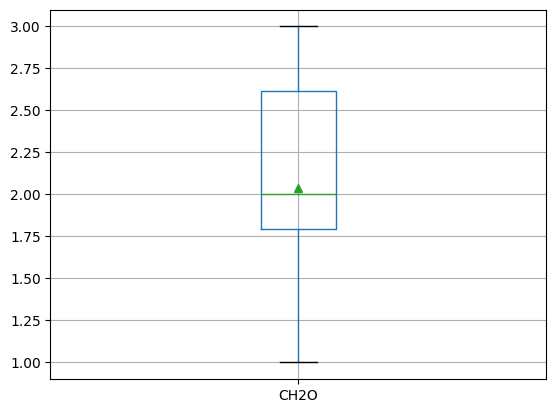

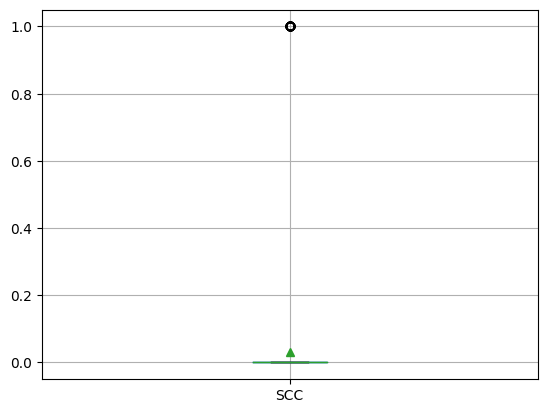

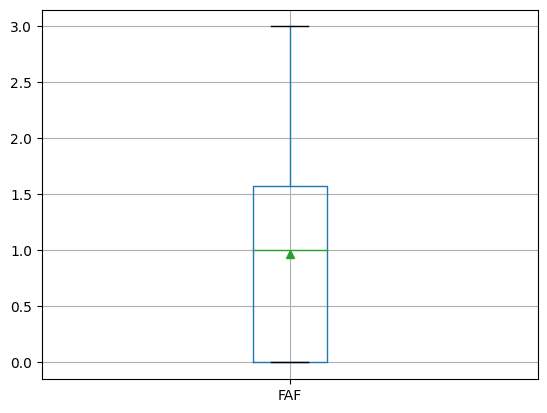

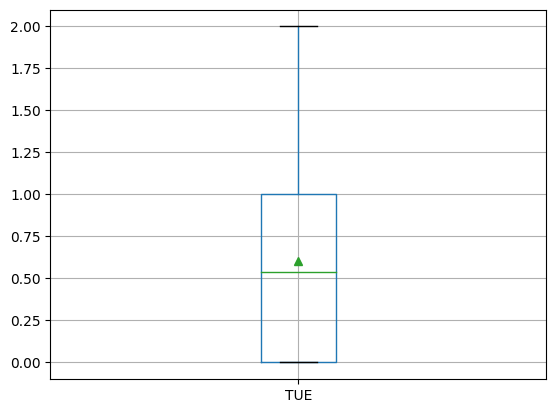

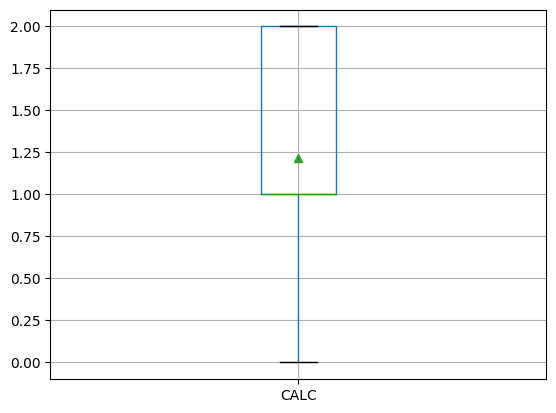

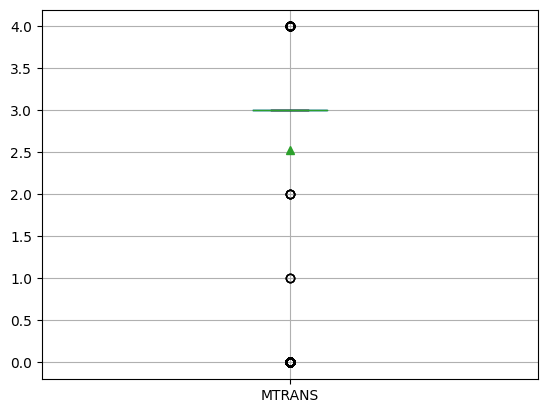

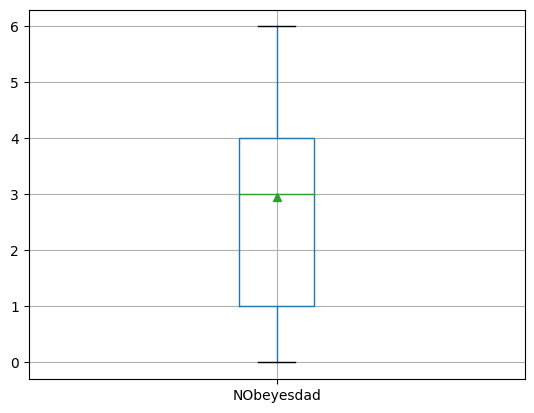

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [23]:
[get_boxplot(df[column], column) for column in df.columns]

### Смотрим на выбросы в процентах

In [24]:
def find_outliers(df):
    outliers = {}
    for col in df.columns:
        v = df[col]
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers_count = ((v < lower_bound) | (v > upper_bound)).sum()
        perc = outliers_count * 100.0 / len(df)
        outliers[col] = (perc, outliers_count)
        print(f"Column {col} outliers = {perc:.2f}%")

    return outliers

outliers = find_outliers(df)

Column Gender outliers = 0.00%
Column Age outliers = 4.75%
Column Height outliers = 0.05%
Column Weight outliers = 0.00%
Column family_history_with_overweight outliers = 20.30%
Column FAVC outliers = 8.90%
Column FCVC outliers = 0.00%
Column NCP outliers = 29.05%
Column CAEC outliers = 16.20%
Column SMOKE outliers = 1.10%
Column CH2O outliers = 0.00%
Column SCC outliers = 3.00%
Column FAF outliers = 0.00%
Column TUE outliers = 0.00%
Column CALC outliers = 0.00%
Column MTRANS outliers = 19.00%
Column NObeyesdad outliers = 0.00%


**Итог**

Можно заметить, что некоторые признаки имеют большой процент выбросов, но на самом деле это не выбросы, а статистика и ее нужно учитывать, поэтому я не буду ничего с ними делать.

 ## Тепловая карта

<Axes: >

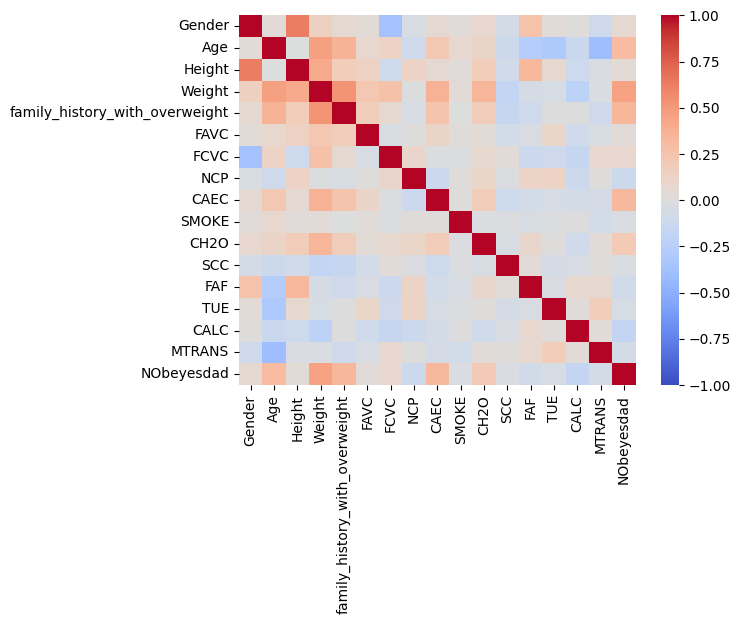

In [25]:
sns.heatmap(df.corr(method='spearman'), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

## Mutual Information

In [26]:
X = df
y = X['NObeyesdad']
X = X.drop('NObeyesdad', axis=1, inplace=False)

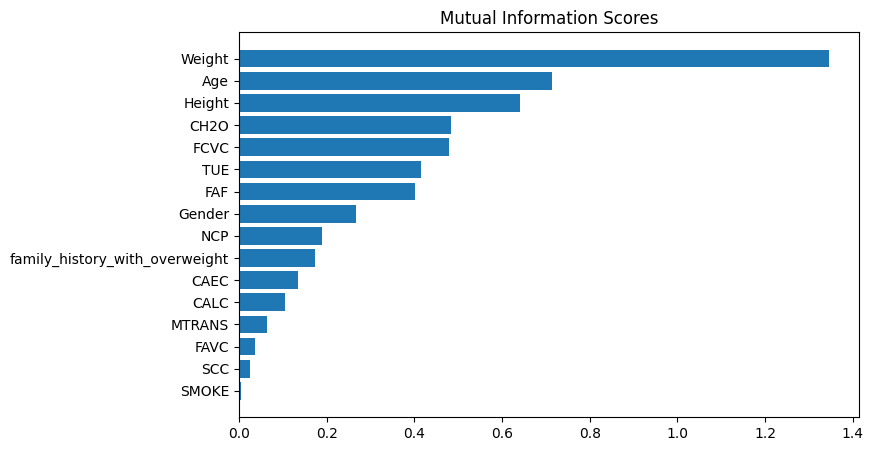

In [27]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

discrete_features = X.dtypes == int
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

**Итог**

Предлагаю удалить SMOKE, FAVC, MTRANS, CALC, потому что они не дают никакой связи ни на тепловой карте Спирмена, ни на графике взаимной информации

In [28]:
X = X.drop(['SMOKE', 'FAVC', 'MTRANS', 'CALC'], axis=1)

## Feature engineering

In [29]:
X['mean'] = X[X.columns].mean(axis=1)
X['std'] = X[X.columns].std(axis=1)
X['max'] = X[X.columns].max(axis=1)
X['median'] = X[X.columns].median(axis=1)

### PCA

In [30]:
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

new_pca_df = pd.DataFrame(
    pca.components_.T,
    columns=component_names,
    index=X.columns,
)
new_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
Gender,0.070000,0.552494,-0.235577,-0.169934,0.033909,0.004419,0.053213,0.005532,-0.269137,0.382116,0.061886,-0.615318,-0.014167,0.012226,1.358928e-03,-1.413238e-02
Age,0.177077,-0.200247,-0.322262,-0.369365,-0.005014,-0.337372,0.308311,-0.132072,0.037495,0.167396,0.590353,0.239999,-0.032128,0.007795,1.521890e-02,-1.582712e-01
Height,0.185352,0.525053,-0.032145,-0.061618,-0.172286,0.078406,-0.094717,0.072936,-0.190108,0.224398,-0.156863,0.708794,0.146683,-0.000077,2.384564e-04,-2.479864e-03
Weight,0.416186,-0.010476,-0.054035,0.067792,-0.105170,0.129239,-0.071209,-0.002718,-0.028034,-0.212845,-0.004516,-0.088881,-0.001582,-0.303794,-6.680442e-01,-4.401556e-01
family_history_with_overweight,0.258865,-0.036754,-0.165060,0.168336,0.039903,-0.078802,0.290261,-0.258781,0.577587,0.394022,-0.475755,-0.016983,-0.037008,0.006706,1.093224e-03,-1.136915e-02
FCVC,0.137999,-0.332148,0.316435,-0.030228,-0.330219,0.128625,-0.402919,0.125068,-0.005973,0.607225,0.136634,-0.046056,-0.276043,0.006364,1.439883e-03,-1.497429e-02
NCP,0.065384,0.148683,0.367013,0.066063,-0.422481,-0.504615,0.419868,0.364797,-0.036225,-0.131627,-0.105236,-0.075513,-0.236986,0.009030,1.924130e-03,-2.001029e-02
CAEC,0.181871,-0.066797,-0.095069,0.024871,0.568625,0.095225,0.080090,0.758191,0.073123,0.105729,-0.001425,0.072964,-0.130692,0.006286,1.222506e-03,-1.271364e-02
CH2O,0.190896,0.092729,0.416895,-0.071867,0.483685,-0.029399,0.084674,-0.422828,-0.262961,-0.022773,-0.046984,0.103886,-0.521730,0.006946,1.677629e-03,-1.744676e-02
SCC,-0.093510,-0.053541,0.168646,-0.333078,-0.182105,0.703411,0.564886,0.032737,0.023340,-0.000371,0.001367,0.003127,-0.017462,0.002229,4.636372e-04,-4.821666e-03


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

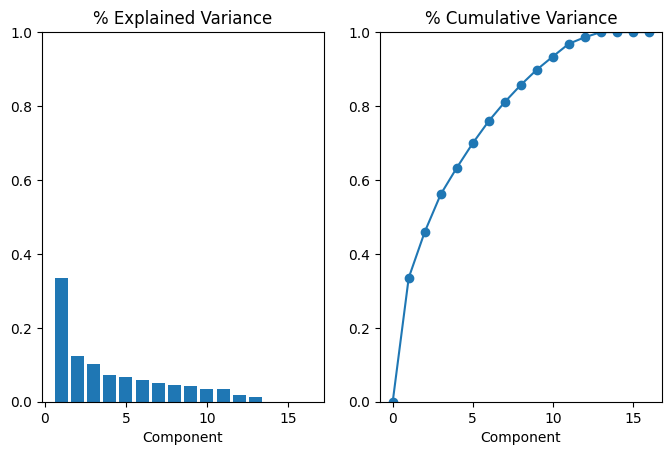

In [31]:
plot_variance(pca)

**Замечание**

Давайте оставим только 10 компонент, так как они объясняют процентов 90% всей информации

In [32]:
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

pca_df = pd.DataFrame(
    pca.components_.T,
    columns=component_names,
    index=X.columns,
)
X_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1.519513,-1.846846,-0.763019,0.937397,-1.243737,0.120869,-0.057677,0.720108,0.200577,-0.139929
1,-1.213677,1.637494,0.121962,0.428964,0.260559,0.222085,-0.328709,0.970094,-1.428129,-0.693525
2,0.902628,-0.377688,2.320806,-1.062318,0.903121,-0.637931,-0.453528,-0.147053,0.941080,0.303650
3,1.800855,0.006920,-1.959110,-0.417097,0.196022,-0.646025,1.238881,-0.106577,-0.770236,-0.994987
4,-3.466350,0.733366,0.375160,2.014462,0.977034,-0.049306,0.667127,0.765758,-1.746128,0.212157
...,...,...,...,...,...,...,...,...,...,...
1995,-0.186552,1.120776,0.430829,0.900376,1.263083,0.028582,0.546468,-0.423968,-0.223662,-0.182781
1996,-0.140444,1.349929,-0.550109,1.791211,0.369043,0.018853,1.092039,0.019523,0.259596,0.352749
1997,1.150192,-0.931702,-2.810430,-1.153902,0.320857,-2.212532,2.843210,-0.691785,-0.366520,1.082335
1998,-1.006527,-0.854182,-0.246629,1.371257,3.779294,1.460461,-0.316796,0.483044,-0.504768,-0.872029


# Разделение на train/test

In [36]:
y.reset_index(drop=True, inplace=True)

In [37]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.3, random_state=42)

In [38]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test_pca, y_test_pca, test_size=0.5, random_state=42)

# Поговорим про метрики

***На какую метрику мне больше всего выгоднее смотреть?***

- Precision показывает долю правильно-положительных ответов среди всех положительных ответов.  То есть Precision демонстрирует способность модели отличать этот класс от других.

- Recall показывает долю правильно-положительных ответов среди всех положительных. То есть Recall демонстрирует способность модели находить этот класс в целом.

- F-1 - баланс между этими двумя метриками, очев.


По-хорошему надо бы смотреть на все три метрики, но на F-1 и Recall в особенности. Потому что F-1 более информативная, а Recall нам нужно здесь больше, так как если модель пропустит человека с высокой степень ожирения и его не проверят, то будет намного хуже (Recall) чем если бы модель причислила класс высокого ожирения человеку, у которого его нет (Precision).

Лучше проверить, чем недопроверить!

# Дерево решений

## Моя реализация

### Подбираем параметр min_samples_split, не ограничевая высоту

In [ ]:
arr_split = range(10, 30, 3)
results, arr_var, arr_sse, arr_bias = [], [], [], []
for split in arr_split:
    tree = DecisionTree(max_depth=100, min_samples_split=split, criterion="entropy", leaf_func="classification_leaf")
    tree.fit(X_train_pca, y_train_pca)
    preds_tree = tree.predict(X_test_pca)
    mean_f1 = output_metrics_classification(label_encoder.inverse_transform(preds_tree), label_encoder.inverse_transform(y_test_pca))
    results.append(mean_f1['macro avg']['f1-score'])

    variance = np.var(preds_tree)
    sse = np.mean((np.mean(preds_tree) - y)** 2)
    bias = sse - variance

    arr_var.append(variance)
    arr_sse.append(sse)
    arr_bias.append(bias)

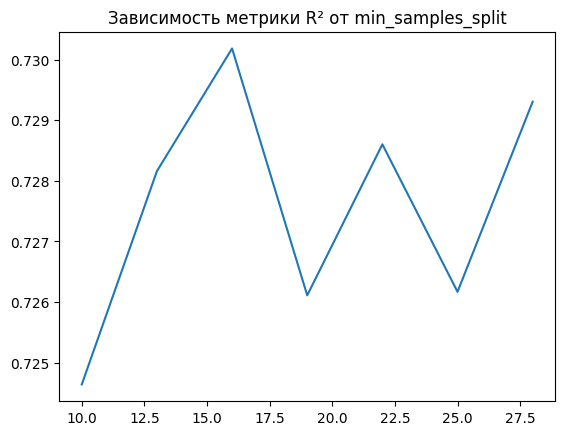

In [ ]:
get_2d(arr_split, results, 'min_samples_split')

In [ ]:
get_bias_variance(arr_split, arr_bias, arr_var, arr_sse, "min_samples_leaf", "Decision Tree")

### Подбираем параметр min_samples_leaf, не ограничивая высоту

In [ ]:
arr_leaf = range(7, 25, 3)
results, arr_var, arr_sse, arr_bias = [], [], [], []
for leaf in arr_leaf:
    tree = DecisionTree(max_depth=100, min_samples_leaf=leaf, criterion="entropy", leaf_func="classification_leaf")
    tree.fit(X_train_pca, y_train_pca)
    preds_tree = tree.predict(X_test_pca)
    mean_f1 = output_metrics_classification(label_encoder.inverse_transform(preds_tree), label_encoder.inverse_transform(y_test_pca))
    results.append(mean_f1['macro avg']['f1-score'])

    variance = np.var(preds_tree)
    sse = np.mean((np.mean(preds_tree) - y)** 2)
    bias = sse - variance

    arr_var.append(variance)
    arr_sse.append(sse)
    arr_bias.append(bias)

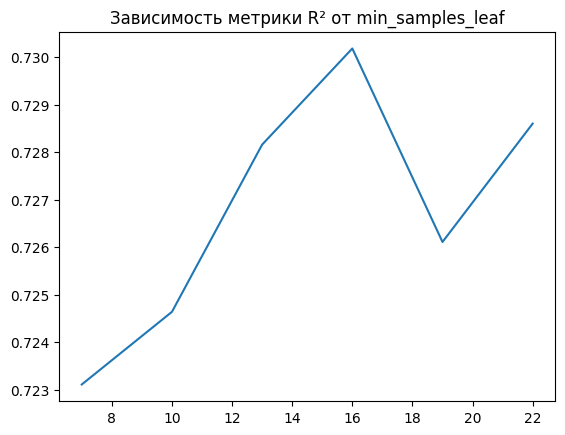

In [ ]:
get_2d(arr_leaf, results, 'min_samples_leaf')

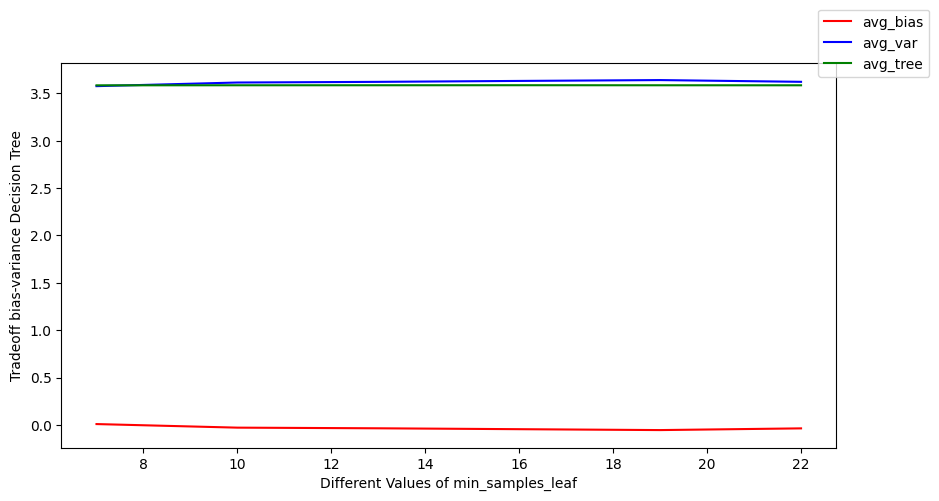

In [ ]:
get_bias_variance(arr_leaf, arr_bias, arr_var, arr_sse, "min_samples_leaf", "Decision Tree")

### Переберем высоты и посмотрим, какая лучше

In [ ]:
arr_depth = range(10, 30, 2)
results = []
for depth in tqdm(arr_depth):
    tree = DecisionTree(max_depth=depth, min_samples_split=10, min_samples_leaf=7, criterion="entropy", leaf_func="classification_leaf")
    tree.fit(X_train_pca, y_train_pca)
    preds_tree = tree.predict(X_test_pca)
    mean_f1 = output_metrics_classification(label_encoder.inverse_transform(preds_tree), label_encoder.inverse_transform(y_test_pca))
    results.append(mean_f1['macro avg']['f1-score'])

100%|██████████| 10/10 [22:09<00:00, 132.97s/it]


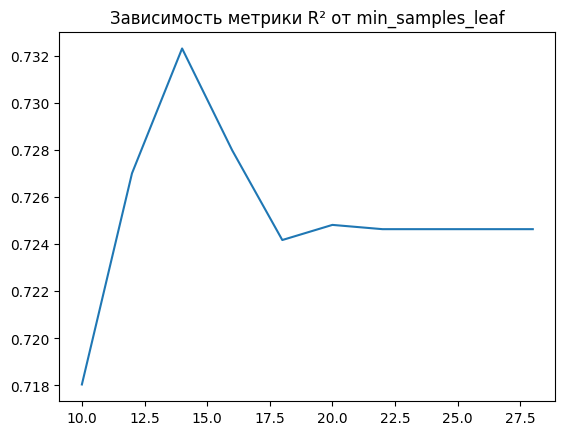

In [ ]:
get_2d(arr_depth, results, 'min_samples_leaf')

**Итог:**
Давайте посмотрим на метрики последних двух классов: Overweight_Level_II и Overweight_Level_I.
- маленькая Precision у того и того класса означает, что моя модель дала дала много ложно-положительных ответов. То есть она причисляет объектам с отрицательным таргетом положительный класс.

- маленькая Recall у того и того класса означает, что моя модель дала дала много ложно-отрицательных ответов. То есть она причисляет объект с положительным таргетом к другим классам.

**Вывод такой:** модель не умеет не отличать эти класс от других, не находить их.

 Почему так произошло? Потому что судя по support и распределению таргета, имеется дисбаланс классов, а дерево решений зависимо от баланса класов.

Скорее всего последние два класса путаются с Obesity_Type_I и Obesity_Type_III

### Перебор гиперпараметров

In [39]:
def my_objective(trial):
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    max_depth = trial.suggest_int('max_depth', 5, 30)
    max_leaf_size = trial.suggest_int('max_leaf_size', 5, 20)
    tree = DecisionTree(max_depth=max_depth, min_samples_split=10, min_samples_leaf=max_leaf_size, criterion=criterion, leaf_func="classification_leaf")
    tree.fit(X_train_pca, y_train_pca)
    mean_f1 = output_metrics_classification(label_encoder.inverse_transform(tree.predict(X_valid)), label_encoder.inverse_transform(y_valid))
    return mean_f1['macro avg']['f1-score']

study = optuna.create_study(direction='maximize')
study.optimize(my_objective, n_trials=20)
print(study.best_params)

[I 2024-10-17 10:56:07,786] A new study created in memory with name: no-name-dd31743c-1e73-430f-be0c-1ca27fd1c08e
[I 2024-10-17 10:56:27,702] Trial 0 finished with value: 0.6256497970357312 and parameters: {'criterion': 'gini', 'max_depth': 29, 'max_leaf_size': 10}. Best is trial 0 with value: 0.6256497970357312.
[I 2024-10-17 10:56:43,806] Trial 1 finished with value: 0.6256497970357312 and parameters: {'criterion': 'gini', 'max_depth': 19, 'max_leaf_size': 8}. Best is trial 0 with value: 0.6256497970357312.
[I 2024-10-17 10:56:45,453] Trial 2 finished with value: 0.6147341807682658 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_size': 9}. Best is trial 0 with value: 0.6256497970357312.
[I 2024-10-17 10:56:52,570] Trial 3 finished with value: 0.6500216184706739 and parameters: {'criterion': 'gini', 'max_depth': 8, 'max_leaf_size': 19}. Best is trial 3 with value: 0.6500216184706739.
[I 2024-10-17 10:56:59,254] Trial 4 finished with value: 0.6592266371544312 and par

{'criterion': 'entropy', 'max_depth': 14, 'max_leaf_size': 20}


In [40]:
optuna.visualization.plot_slice(study)

## Sklearn реализация

### Подбираем параметр min_samples_split, не ограничевая высоту

In [ ]:
arr_split = range(10, 30, 3)
best_f1 = -1
results = []
for split in arr_split:
    tree = DecisionTreeClassifier(max_depth=100, min_samples_split=split, criterion="entropy")
    tree.fit(X_train_pca, y_train_pca)
    preds_tree = tree.predict(X_test_pca)
    mean_f1 = output_metrics_classification(label_encoder.inverse_transform(preds_tree), label_encoder.inverse_transform(y_test_pca))
    results.append(mean_f1['macro avg']['f1-score'])

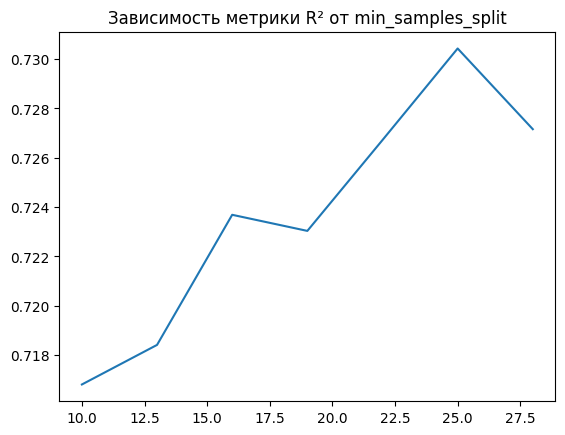

In [ ]:
get_2d(arr_split, results, 'min_samples_split')

### Подбираем параметр min_samples_leaf, не ограничивая высоту

In [ ]:
arr_leaf = range(7, 25, 3)
best_f1 = -1
results = []
for leaf in arr_leaf:
    tree = DecisionTreeClassifier(max_depth=100, min_samples_leaf=leaf, criterion="entropy")
    tree.fit(X_train_pca, y_train_pca)
    preds_tree = tree.predict(X_test_pca)
    mean_f1 = output_metrics_classification(label_encoder.inverse_transform(preds_tree), label_encoder.inverse_transform(y_test_pca))
    results.append(mean_f1['macro avg']['f1-score'])

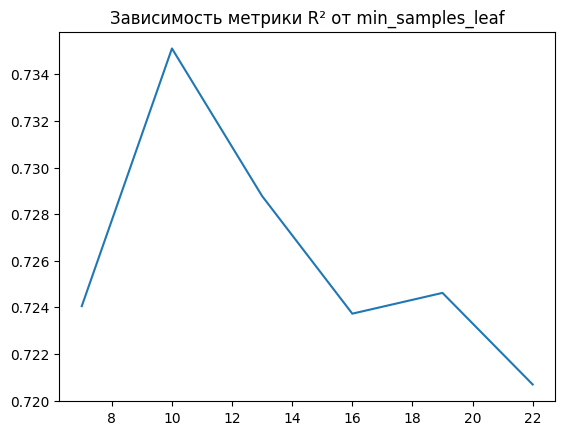

In [ ]:
get_2d(arr_leaf, results, 'min_samples_leaf')

### Переберем высоты и посмотрим, какая лучше

In [ ]:
arr_depth = range(10, 30, 2)
results = []
for depth in tqdm(arr_depth):
    tree = DecisionTreeClassifier(max_depth=depth, min_samples_split=25, min_samples_leaf=11, criterion="entropy")
    tree.fit(X_train_pca, y_train_pca)
    preds_tree = tree.predict(X_test_pca)
    mean_f1 = output_metrics_classification(label_encoder.inverse_transform(preds_tree), label_encoder.inverse_transform(y_test_pca))
    results.append(mean_f1['macro avg']['f1-score'])

100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


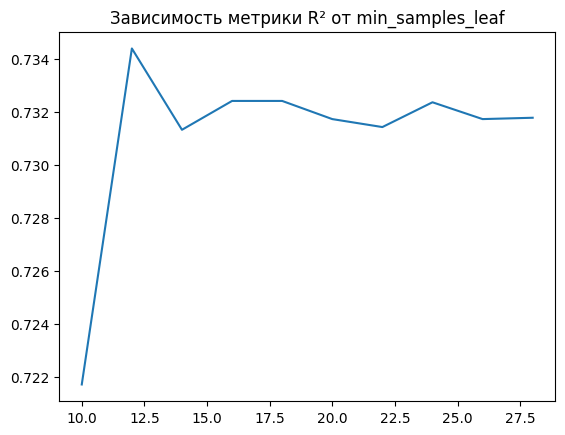

In [ ]:
get_2d(arr_depth, results, 'max_depth')

### Перебор гиперпараметров

In [ ]:
def sklearn_objective(trial):
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini', 'log_loss'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    classifier = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split
    )
    classifier.fit(X_train_pca, y_train_pca)
    mean_f1 = output_metrics_classification(classifier.predict(X_valid), y_valid)
    return mean_f1['macro avg']['f1-score']

study = optuna.create_study(direction='maximize')
study.optimize(sklearn_objective, n_trials=100)
print(study.best_params)

[I 2024-10-17 06:13:15,637] A new study created in memory with name: no-name-305a35ae-fe56-4a9b-afcf-60c90bbed99a
[I 2024-10-17 06:13:15,723] Trial 0 finished with value: 0.47451873139731676 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 61, 'min_samples_split': 64}. Best is trial 0 with value: 0.47451873139731676.
[I 2024-10-17 06:13:15,778] Trial 1 finished with value: 0.5708858160479016 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 73, 'min_samples_split': 76}. Best is trial 1 with value: 0.5708858160479016.
[I 2024-10-17 06:13:15,856] Trial 2 finished with value: 0.6087518983897109 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 14, 'min_samples_split': 81}. Best is trial 2 with value: 0.6087518983897109.
[I 2024-10-17 06:13:15,907] Trial 3 finished with value: 0.614470360908698 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 91, 'min_samples_split': 27}. Best is trial 3 wit

{'criterion': 'gini', 'splitter': 'best', 'max_depth': 100, 'min_samples_split': 7}


In [ ]:
optuna.visualization.plot_slice(study)

# Случайный лес

## Моя реализация

### Подбор гиперпараметров

In [41]:
def my_objective(trial):
    n_estimators = trial.suggest_int('max_depth', 5, 15, 2)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    max_leaf_size = trial.suggest_int('max_leaf_size', 5, 20)
    tree = RandomForest(max_depth=max_depth, min_samples_split=10, min_samples_leaf=max_leaf_size, criterion="entropy", leaf_func="classification_leaf", N=n_estimators)
    tree.fit(X_train_pca, y_train_pca)
    mean_f1 = output_metrics_classification(label_encoder.inverse_transform(tree.predict(X_valid)), label_encoder.inverse_transform(y_valid))
    return mean_f1['macro avg']['f1-score']

study = optuna.create_study(direction='maximize')
study.optimize(my_objective, n_trials=20)
print(study.best_params)


[I 2024-10-17 11:00:16,675] A new study created in memory with name: no-name-4e94845d-6f2a-40ae-aa63-a4a1f2712454
[I 2024-10-17 11:01:34,504] Trial 0 finished with value: 0.7308322131500162 and parameters: {'max_depth': 9, 'max_leaf_size': 19}. Best is trial 0 with value: 0.7308322131500162.
[I 2024-10-17 11:01:43,380] Trial 1 finished with value: 0.6570246875083418 and parameters: {'max_depth': 5, 'max_leaf_size': 13}. Best is trial 0 with value: 0.7308322131500162.
[I 2024-10-17 11:03:50,561] Trial 2 finished with value: 0.7209575754017298 and parameters: {'max_depth': 13, 'max_leaf_size': 17}. Best is trial 0 with value: 0.7308322131500162.
[I 2024-10-17 11:03:59,355] Trial 3 finished with value: 0.6437315957429092 and parameters: {'max_depth': 5, 'max_leaf_size': 16}. Best is trial 0 with value: 0.7308322131500162.
[I 2024-10-17 11:06:11,614] Trial 4 finished with value: 0.7227166480516628 and parameters: {'max_depth': 13, 'max_leaf_size': 15}. Best is trial 0 with value: 0.7308322

{'max_depth': 11, 'max_leaf_size': 5}


In [42]:
optuna.visualization.plot_slice(study)

## Sklearn реализация

### Подбор гиперпараметров

In [ ]:
def sklearn_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 100)
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 1, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split
    )
    classifier.fit(X_train_pca, y_train_pca)
    mean_f1 = output_metrics_classification(classifier.predict(X_valid), y_valid)
    return mean_f1['macro avg']['f1-score']

study = optuna.create_study(direction='maximize')
study.optimize(sklearn_objective, n_trials=100)
print(study.best_params)

[I 2024-10-17 06:14:36,717] A new study created in memory with name: no-name-4bebd59f-95d5-46f7-acdc-718e32dfad76
[I 2024-10-17 06:14:36,884] Trial 0 finished with value: 0.7073222764823707 and parameters: {'n_estimators': 21, 'criterion': 'log_loss', 'max_depth': 37, 'min_samples_split': 43}. Best is trial 0 with value: 0.7073222764823707.
[I 2024-10-17 06:14:37,053] Trial 1 finished with value: 0.6950152975357291 and parameters: {'n_estimators': 23, 'criterion': 'log_loss', 'max_depth': 34, 'min_samples_split': 64}. Best is trial 0 with value: 0.7073222764823707.
[I 2024-10-17 06:14:37,303] Trial 2 finished with value: 0.6351021707093237 and parameters: {'n_estimators': 37, 'criterion': 'log_loss', 'max_depth': 53, 'min_samples_split': 72}. Best is trial 0 with value: 0.7073222764823707.
[I 2024-10-17 06:14:38,191] Trial 3 finished with value: 0.6324827056964827 and parameters: {'n_estimators': 93, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 27}. Best is trial 0 with

{'n_estimators': 62, 'criterion': 'log_loss', 'max_depth': 65, 'min_samples_split': 4}


In [ ]:
optuna.visualization.plot_slice(study)

### Смотрим на зависимости от количества деревьев на train/test датасете

In [46]:
results_train = []
results_test = []
n_estimators = range(5, 20, 2)
for estimators in n_estimators:
      tree = RandomForestClassifier(max_depth=65, min_samples_split=4,criterion="log_loss", n_estimators=estimators)
      tree.fit(X_train_pca, y_train_pca)
      preds_tree_test = tree.predict(X_test_pca)
      mean_f1_test = output_metrics_classification(label_encoder.inverse_transform(preds_tree_test), label_encoder.inverse_transform(y_test_pca))
      results_test.append(mean_f1_test['macro avg']['f1-score'])

      preds_tree_train = tree.predict(X_train_pca)
      mean_f1_train = output_metrics_classification(label_encoder.inverse_transform(preds_tree_train), label_encoder.inverse_transform(y_train_pca))
      results_train.append(mean_f1_train['macro avg']['f1-score'])

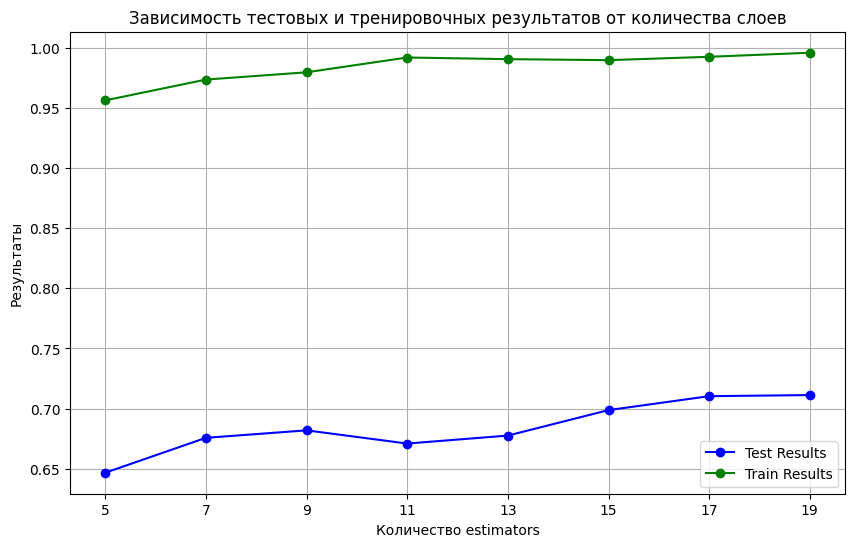

In [47]:
show_dependencies(n_estimators, results_train, results_test)

# Градиентный бустинг

## Моя реализация

## Перебор гиперпараметров

In [ ]:
def sklearn_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 30, 2)
    learning_rate = trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 5)
    classifier = GradientBoosting(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
    classifier.fit(X_train_pca, y_train_pca)
    mean_f1 = output_metrics_classification(classifier.predict(X_valid), y_valid)
    return mean_f1['macro avg']['f1-score']

study = optuna.create_study(direction='maximize')
study.optimize(sklearn_objective, n_trials=100)
print(study.best_params)

[I 2024-10-17 06:30:30,901] A new study created in memory with name: no-name-38593f8c-f531-40b6-9a0f-36611b47ca7e
[I 2024-10-17 06:30:32,924] Trial 0 finished with value: 0.6969598743153768 and parameters: {'n_estimators': 24, 'learning_rate': 0.025011270010503243, 'max_depth': 3}. Best is trial 0 with value: 0.6969598743153768.
[I 2024-10-17 06:30:34,064] Trial 1 finished with value: 0.6582409848181684 and parameters: {'n_estimators': 20, 'learning_rate': 0.0451016896629425, 'max_depth': 2}. Best is trial 0 with value: 0.6969598743153768.
[I 2024-10-17 06:30:35,219] Trial 2 finished with value: 0.5818750651147931 and parameters: {'n_estimators': 20, 'learning_rate': 0.016626237934773316, 'max_depth': 2}. Best is trial 0 with value: 0.6969598743153768.
[I 2024-10-17 06:30:36,442] Trial 3 finished with value: 0.6696129028021954 and parameters: {'n_estimators': 24, 'learning_rate': 0.07540863612879757, 'max_depth': 2}. Best is trial 0 with value: 0.6969598743153768.
[I 2024-10-17 06:30:3

{'n_estimators': 24, 'learning_rate': 0.04725259022917952, 'max_depth': 5}


In [ ]:
optuna.visualization.plot_slice(study)

## Sklearn реализация

### Перебор гиперпараметров

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

def sklearn_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 30, 2)
    learning_rate = trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 5)
    classifier = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
    )
    classifier.fit(X_train_pca, y_train_pca)
    mean_f1 = output_metrics_classification(classifier.predict(X_valid), y_valid)
    return mean_f1['macro avg']['f1-score']

study = optuna.create_study(direction='maximize')
study.optimize(sklearn_objective, n_trials=100)
print(study.best_params)

[I 2024-10-17 06:19:55,611] A new study created in memory with name: no-name-2d55edc0-d4ce-44fe-bfce-4b8b64c2d1b2
[I 2024-10-17 06:19:59,616] Trial 0 finished with value: 0.722418504659277 and parameters: {'n_estimators': 22, 'learning_rate': 0.044760721091155815, 'max_depth': 4}. Best is trial 0 with value: 0.722418504659277.
[I 2024-10-17 06:20:01,400] Trial 1 finished with value: 0.6974128953190313 and parameters: {'n_estimators': 18, 'learning_rate': 0.04090003354806584, 'max_depth': 4}. Best is trial 0 with value: 0.722418504659277.
[I 2024-10-17 06:20:06,931] Trial 2 finished with value: 0.6957516558752113 and parameters: {'n_estimators': 28, 'learning_rate': 0.011596442378196998, 'max_depth': 5}. Best is trial 0 with value: 0.722418504659277.
[I 2024-10-17 06:20:11,444] Trial 3 finished with value: 0.6989984120847798 and parameters: {'n_estimators': 24, 'learning_rate': 0.034982778306726754, 'max_depth': 3}. Best is trial 0 with value: 0.722418504659277.
[I 2024-10-17 06:20:18,4

{'n_estimators': 12, 'learning_rate': 0.08065064943999099, 'max_depth': 5}


In [ ]:
optuna.visualization.plot_slice(study)